# Overview

The following notebook will:
 * Define two graph convolutional neural network models
 * Define a series of functions for training and testing the models
 * Import and load the B3DB dataset which has been pre-processed into a list of torch tensors
 * Run a series of preliminary experiments to assess the quality of the model on the BBB classification task
 * Run and briefly analyze a simple hyper-parameter search for one of the models

#### Note:
Some of the cells are computationally very expensive and their outputs have been pickled as '.pt' files. If you want to use the notebook interactively, we reccomend that you run the torch.load cells instead to save time.

In [526]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch_geometric as tgn
from torch.nn import Sequential as Seq, Linear, ReLU
from torch_geometric.utils import add_self_loops, degree
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data
import torch.nn.functional as F

from torch_geometric.loader import DataLoader

from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

from tqdm import tqdm

# Model Definition

#### 1 output channel model

In [490]:
class GCN_binary(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN_binary, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(30, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 1)

    def forward(self, x, edge_index, batch):
        # Convolution layers 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # pooling
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # Randomly zeros some values from the input tensor according to a bernouli distribution
        # helps avoid over-fitting by minimizing learned co-dependence of 
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Apply a final classifier
        x = self.lin(x)
        
        return x

#### 2 output channel model

In [403]:
class GCN_2channel_out(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN_2channel_out, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(30, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)

    def forward(self, x, edge_index, batch):
        # Convolution layers 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # pooling
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

# Training / Eval Functions

#### 2 output channels

In [392]:
def train_one_epoch_2channels(model, data_loader, optimizer, loss_fn):
    
    model.train()
    loss_sum = []
    for _, batch in enumerate(data_loader):
        optimizer.zero_grad()

        model_out = model(batch.x.float(), batch.edge_index, batch.batch)
        loss = loss_fn(model_out, batch.y)

        loss.backward()  
        optimizer.step()
        
        # metrics
        loss_sum.append(loss.detach().numpy())
        
    return np.array(loss_sum).sum() / len(data_loader)
    

In [393]:
def test_2channels(loader):
    model.eval()
    correct = 0
    for data in loader:
        out = model(data.x.float(), data.edge_index, data.batch)          
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

#### 1 output channel

In [394]:
def train_one_epoch_1channel(model, data_loader, optimizer, loss_fn):
    model.train()
    loss_sum = []
    for _, batch in enumerate(data_loader):
        optimizer.zero_grad()
        
        model_out = torch.sigmoid(model(batch.x.float(), batch.edge_index, batch.batch))
        loss = loss_fn(torch.squeeze(model_out), batch.y.float())

        loss.backward()  
        optimizer.step()
        
        # metrics
        loss_sum.append(loss.detach().numpy())
        
    return np.array(loss_sum).sum() / len(data_loader)
    

In [395]:
def test_1channel(loader):
    model.eval()
    correct = 0
    for data in loader:        
        out = torch.sigmoid(model(data.x.float(), data.edge_index, data.batch))
        pred = torch.tensor([1.0 if res > 0.5 else 0 for res in out])
        
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

### Helper Methods

In [338]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Message Passing Pyg Experiments

### Rich Dataset

In [446]:
import random
random.seed(1)

In [460]:
rich_data = torch.load('rich_dataset.pt') # 30 node features, 11 edge features

  0%|                                                                                                    | 0/1000 [51:23<?, ?it/s]


In [461]:
rich_data[0]

Data(x=[28, 30], edge_index=[2, 60], edge_attr=[60, 11], y=0)

In [560]:
len(rich_data)

7800

In [566]:
# Can pass BBB
sum([1 if d.y==1.0 else 0 for d in rich_data])

4949

In [568]:
# Can NOT pass BBB
sum([1 if d.y==0.0 else 0 for d in rich_data])

2851

In [462]:
random.shuffle(rich_data)

In [463]:
train_loader = DataLoader(rich_data[:int(len(rich_data)*0.9)], batch_size=32, shuffle=True)
test_loader = DataLoader(rich_data[int(len(rich_data)*0.9):], batch_size=32, shuffle=True)

## Train
#### Binary Cross Entropy Loss

In [464]:
model = GCN_binary(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# loss_fn = torch.nn.CrossEntropyLoss()
loss_fn = torch.nn.BCELoss()

In [465]:
print('num model params:', count_parameters(model))

num model params: 10369


In [466]:
epochs = 500

losses = []
test_scores = []
pbar = tqdm(total = epochs, position=0, leave=True)
for epoch in range(epochs):
    losses.append(  
        (  epoch, train_one_epoch_1channel(model, train_loader, optimizer, loss_fn)  )
                 )
    if epoch % 5 == 0:
        test_scores.append((epoch, test_1channel(test_loader)))    
        
    pbar.update(1)
    
pbar.close()

100%|███████████████████████████████████████████████████████████████████████████████████████████| 500/500 [14:20<00:00,  1.72s/it]


In [467]:
binary_losses = losses

In [468]:
binary_test_scores = test_scores

In [469]:
binary_losses[-5:]

[(495, 0.20492987199263138),
 (496, 0.20252607518976384),
 (497, 0.1958147569136186),
 (498, 0.20087942643599077),
 (499, 0.20502471923828125)]

In [470]:
binary_test_scores[-10:]

[(450, 0.8512820512820513),
 (455, 0.85),
 (460, 0.8333333333333334),
 (465, 0.8538461538461538),
 (470, 0.8423076923076923),
 (475, 0.8423076923076923),
 (480, 0.8461538461538461),
 (485, 0.8512820512820513),
 (490, 0.8487179487179487),
 (495, 0.8487179487179487)]

In [471]:
binary_model = model

#### Cross Entropy Loss

In [472]:
train_loader = DataLoader(rich_data[:int(len(rich_data)*0.9)], batch_size=32, shuffle=True)
test_loader = DataLoader(rich_data[int(len(rich_data)*0.9):], batch_size=32, shuffle=True)

In [473]:
model = GCN_2channel_out(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()

print('num model params:', count_parameters(model))

num model params: 10434


In [474]:
epochs = 500

losses = []
test_scores = []
pbar = tqdm(total = epochs, position=0, leave=True)
for epoch in range(epochs):
    losses.append(  
        (  epoch, train_one_epoch_2channels(model, train_loader, optimizer, loss_fn)  )
                 )
    if epoch % 5 == 0:
        test_scores.append((epoch, test_2channels(test_loader)))    
        
    pbar.update(1)
    
pbar.close()

100%|███████████████████████████████████████████████████████████████████████████████████████████| 500/500 [13:28<00:00,  1.62s/it]


In [475]:
losses_2chan = losses
test_scores_2chan = test_scores

In [476]:
model_2chan = model

In [478]:
losses_2chan[-5:]

[(495, 0.21938018798828124),
 (496, 0.2179456364024769),
 (497, 0.2178177920254794),
 (498, 0.2228319688276811),
 (499, 0.21928435238924893)]

In [479]:
test_scores_2chan[-10:]

[(450, 0.8512820512820513),
 (455, 0.8397435897435898),
 (460, 0.8538461538461538),
 (465, 0.85),
 (470, 0.8474358974358974),
 (475, 0.8487179487179487),
 (480, 0.8525641025641025),
 (485, 0.8564102564102564),
 (490, 0.8474358974358974),
 (495, 0.8551282051282051)]

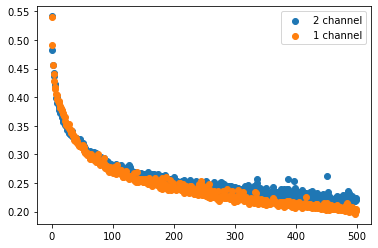

In [482]:
### Vis
losses_2chan = np.array(losses_2chan)
binary_losses = np.array(binary_losses)


plt.scatter(losses_2chan[:,0],losses_2chan[:,1] , label='2 channel')
plt.scatter(binary_losses[:,0],binary_losses[:,1] , label='1 channel')

plt.legend()

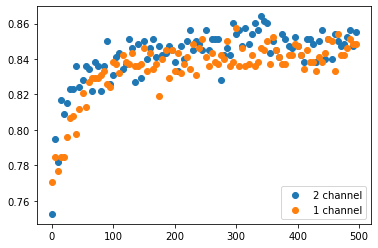

In [483]:
### Vis
test_scores_2chan = np.array(test_scores_2chan)
binary_test_scores = np.array(binary_test_scores)


plt.scatter(test_scores_2chan[:,0],test_scores_2chan[:,1] , label='2 channel')
plt.scatter(binary_test_scores[:,0],binary_test_scores[:,1] , label='1 channel')

plt.legend()

# Hyperparameter exploration
In order to get *some* idea of optimal hyperparameters, we test learning rate and number of  We run the model for 75 epochs per hyper-parameter permutation, saving the training loss and test accuracy at each epoch and every 5th epoch respectively/

In [494]:
# test all these hyperparams for Adam and SGD optimizers
lrs = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.1]
channels = [8, 16, 32, 64, 128]

epochs = 75

rich_data = torch.load('rich_dataset.pt') # 30 node features, 11 edge features
random.seed(1)
random.shuffle(rich_data)

train_loader = DataLoader(rich_data[:int(len(rich_data)*0.9)], batch_size=32, shuffle=True)
test_loader = DataLoader(rich_data[int(len(rich_data)*0.9):], batch_size=32, shuffle=True)

total = len(lrs) * len(channels) * epochs
pbar = tqdm(total=total , position=0, leave=True)

res_dict = {}
for lr in lrs:
    
    for n_chans in channels:
        
        model = GCN_binary(hidden_channels=n_chans)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        loss_fn = torch.nn.BCELoss()
        
        losses = []
        test_scores = []
        for epoch in range(epochs):
            losses.append(  
                (  epoch, train_one_epoch_1channel(model, train_loader, optimizer, loss_fn)  )
            )
            if epoch % 5 == 0:
                test_scores.append((epoch, test_1channel(test_loader)))    
            pbar.update(1)
            
        res_dict[str(lr)+'_'+str(n_chans)] = [losses, test_scores]
        
pbar.close() 

100%|███████████████████████████████████████████████████████████████████████████████████████| 3000/3000 [1:17:52<00:00,  1.56s/it]


In [495]:
torch.save(res_dict, 'ADAM_optim_hyperparam_search.pt')

In [497]:
results = []
for key, value in res_dict.items():
    max_score = np.array(value[1])[:,1].max()
    results.append( [key, max_score] )

In [572]:
# BEST:
sorted(results, key=lambda x: x[1], reverse=True)[:5]

[['0.001_64', 0.867948717948718],
 ['0.0025_128', 0.8666666666666667],
 ['0.01_64', 0.8653846153846154],
 ['0.005_64', 0.8641025641025641],
 ['0.005_128', 0.8628205128205129]]

In [573]:
# WORST:
sorted(results, key=lambda x: x[1], reverse=True)[-5:]

[['0.1_8', 0.617948717948718],
 ['0.1_16', 0.617948717948718],
 ['0.1_32', 0.617948717948718],
 ['0.1_64', 0.617948717948718],
 ['0.1_128', 0.617948717948718]]

### 'Correlation Matrix'
(I don't think this is a rigorously defined correlation matrix)

In [608]:
import matplotlib
import matplotlib.cm as cm

In [609]:
lrs = [0.001, 0.0025, 0.005, 0.0075, 0.01, 0.025, 0.05, 0.1]
channels = [8, 16, 32, 64, 128]

vals = np.zeros( (len(lrs),len(channels) ))

for key, value in res_dict.items():
    max_score = np.array(value[1])[:,1].max()
    
    hyp_list = key.split('_')
    i = float(hyp_list[0])
    j = float(hyp_list[1])
    
    vals[lrs.index(i),channels.index(j)] = max_score

In [610]:
vals

array([[0.83205128, 0.83974359, 0.85897436, 0.86794872, 0.86153846],
       [0.84230769, 0.84358974, 0.8525641 , 0.85897436, 0.86666667],
       [0.83717949, 0.86025641, 0.85512821, 0.86410256, 0.86282051],
       [0.83333333, 0.85512821, 0.85897436, 0.85897436, 0.86153846],
       [0.83589744, 0.85641026, 0.85641026, 0.86538462, 0.85512821],
       [0.84487179, 0.85384615, 0.85      , 0.84615385, 0.83076923],
       [0.81923077, 0.81410256, 0.81923077, 0.61794872, 0.61794872],
       [0.61794872, 0.61794872, 0.61794872, 0.61794872, 0.61794872]])

In [620]:
minima = vals.min()
maxima = vals.max()

norm = matplotlib.colors.Normalize(vmin=minima, vmax=maxima, clip=True)

mapper = cm.ScalarMappable(norm=norm, cmap=cm.RdYlGn)
colors = mapper.to_rgba(vals)

Text(0.5, 1.0, 'Best Test Accuracy for GCN Hyperparameter Search')

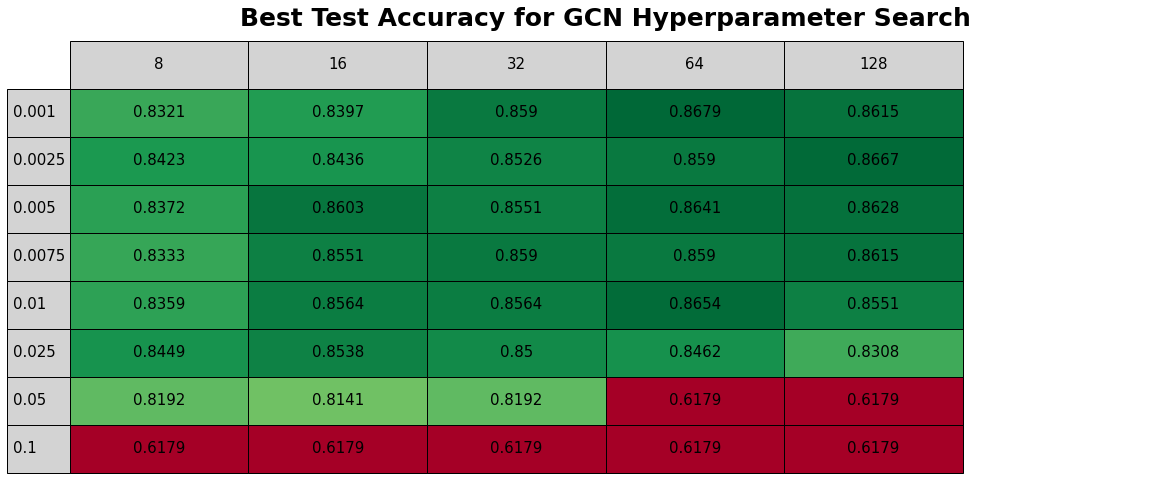

In [658]:
plt.rcParams['figure.figsize'] = (20,8)
fig, ax = plt.subplots()

ax.set_axis_off() 
tab = ax.table(
    cellText=np.around(vals, 4),
    rowLabels=lrs,
    colLabels=channels,
    rowColours =['lightgray'] * len(lrs),  
    colColours =['lightgray'] * len(channels),  
    loc ='upper left',
    cellLoc='center',
    cellColours=colors
)

tab.scale(0.8, 4)
tab.set_fontsize(15)
ax.set_title('Best Test Accuracy for GCN Hyperparameter Search', fontweight ='bold', fontdict={'fontsize': 25})

The above figure plots the best test accuracy performance for each learning rate (rows) and number of hidden layers (cols). 

### Analysis:
A deeper look into the results reveals that the number of hidden layers should be somewhere between 64 and 128
and that a learning rate too high has significant negative effects on performance. There is a trend up and to the right, indicating that in general, a lower learning rate and higher number of hidden channels performs better. 

The best results seem to come from higher number of hidden channels with relatively low learning rate. The optimal ranges seem to be:
 * hidden channels >= 16
 * learning rate <=  0.025
Since the best results fall at the edges of the hyperparameter search that we conducted, a logical next step with more time would be to extend the hyperparameter search to learning rates lower than 0.001 and hidden channels greater than 128.

For our final model(s) that we will train on a greater number of epochs, we will choose:
 * hidden channels - 64 or 128
 * learning rate - 0.001 or 0.0025

There is something of an anomoly in the results where the best test accuracy is 0.6179. It seems improbable that the exact same best score would occur in all of these separate trainings with different hidden channel sizes. My guess is that somewhere on the 'true' decision surface, some of the graphs are relatively easy to classify and others are harder, and that there is some key feature (or features) being learned by models with lower learning rate that models with high learning rate 'skip over'.

It should be noted that the hyper-parameter search was only run on 75 epochs per hyperparameter permutation so it is possible that this is not entirely representative of the hyperparameter space.

## Save Model
Code to save a model's state dict.

In [480]:
path = '/Users/maxperozek/CP341/Proj/CP341_B722_GNN/models/'

In [660]:
save = False

model_to_save = binary_model
if save:
    torch.save(model_to_save.state_dict(), path+'GNN_500epoch_state_dict.pt')